# plot_ripple_trace

plot ripple example for figure 1

In [1]:
import pickle
import numpy as np
# plotting
from matplotlib import pyplot as plt
import dabest
import pandas as pd
from scipy import stats
import h5py
import sys,os
import glob
from ripple_detection import filter_ripple_band
from scipy import signal
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# Continuous Wavelet Transform
import obspy
from obspy.imaging.cm import obspy_sequential
from obspy.signal.tf_misfit import cwt

import sys
sys.path.append("D:/ryanh/github/ripple_analyses")
from functions import *


Bad key "text.kerning_factor" on line 4 in
D:\ryanh\Anaconda3\envs\ripple_analysis\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8
}
plt.style.use('seaborn-paper')
plt.rcParams.update(tex_fonts)

%config InlineBackend.figure_format = 'retina'

## helper functions

In [3]:
def get_good_channels(shank):
    #extract values from dictionary
    an_array = np.array(list(shank.values()),dtype=object)
    
    #loop through array to pull out individual channel        
    good_ch = []
    for i in range(len(an_array)):
        for x in range(len(an_array[i])):
            good_ch.append(an_array[i][x])
        
    return good_ch


def get_lfp(df,i):
    data_path = 'F:\\Projects\\PAE_PlaceCell\\ProcessedData\\'

    # get data session path from mat file
    path = get_session_path(data_path+df.session[i]+'.mat')

    # load xml which has channel & fs info
    channels,fs,shank = loadXML(path)

    # get good channels
    good_ch = get_good_channels(shank)

    # load .lfp
    # lfp, ts = load_lfp(glob.glob(path +'\*.lfp')[0],channels,fs)
    lfp,ts = loadLFP(glob.glob(path +'\*.lfp')[0], n_channels=channels,
                     channel=good_ch, frequency=fs,
                     precision='int16')
    return lfp,ts

def normalize(list, range):
    l = np.array(list) 
    a = np.max(l)
    c = np.min(l)
    b = range[1]
    d = range[0]
    m = (b - d) / (a - c)
    pslope = (m * (l - c)) + d
    return pslope

def get_scalogram(sig,fs=1250,padding=100,f_min=150,f_max=250,fig=1,ax=0):
    
    # sample difference
    dt = 1/fs
    # pad signal
    sig_padded = np.pad(sig, (padding, padding), 'linear_ramp')
    # get time stamps
    t = np.linspace(0, dt * len(sig), len(sig))
    # get scalogram
    scalogram = cwt(sig_padded, dt, 8, f_min, f_max)
    # delete padding
    scalogram = np.delete(scalogram, np.s_[1:padding+1], axis=1) 
    scalogram = np.delete(scalogram, np.s_[-(padding+1):-1], axis=1) 
    
    # plot figure
    if fig==1:
        cmap = plt.get_cmap('magma')
        if ax == 0:
            fig = plt.figure()
            ax = fig.add_subplot(111)

        x, y = np.meshgrid(
            t,
            np.logspace(np.log10(f_min), np.log10(f_max), scalogram.shape[0]))

        im = ax.pcolormesh(x, y, np.abs(scalogram), cmap=cmap,shading='auto')
        ax.set_rasterized(True)
        ax.plot(t,normalize(sig,[f_min,f_max]),color='w',linewidth=1)
        ax.set_ylabel("Frequency [Hz]")
        ax.set_ylim(f_min, f_max)
        # ax.set_yscale('log')
        if ax == 0:
            plt.show()
    
    return np.abs(scalogram),im

## Load data

In [15]:
with open('F:/Projects/PAE_PlaceCell/swr_data/post_processed/swr_df_maps.pkl', 'rb') as f:
    df = pickle.load(f)
    ripple_map = pickle.load(f)
    filtered_map = pickle.load(f)
    phase_map = pickle.load(f)
    amp_map = pickle.load(f)
    freq_map = pickle.load(f)
    
df = df.reset_index()
df['ripple_number'] = np.arange(0,len(df),1)

df = df.drop(columns=['index'])

# add group
control=('RH13','RH14','LS21','LS23','LE2821','LE2823','LEM3116','LEM3120','LEM3216')
pae=('RH11','RH16','LS17','LS19','LE2813','LEM3124','LEM3206','LEM3246')

df['group'] = np.ones_like(df.session)

regstr = '|'.join(control)
idx = df['session'].str.upper().str.contains(regstr)    
df.group[idx] = 'control'

regstr = '|'.join(pae)
idx = df['session'].str.upper().str.contains(regstr)    
df.group[idx] = 'pae'

df

<ipython-input-15-5887d9ea0045>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.group[idx] = 'control'
<ipython-input-15-5887d9ea0045>:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.group[idx] = 'pae'


,ripple_number,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session,rat,group
0,0,66.2624,66.3792,0.1168,0.997065,66.3112,3,6.221621,174.029756,0.000000,LEM3116_S20180715121821,LEM3116,control
1,1,149.9824,150.1512,0.1688,0.989532,150.1128,1,6.893002,217.563367,0.006667,LEM3116_S20180715121821,LEM3116,control
2,2,343.5024,343.5952,0.0928,0.995268,343.5472,3,7.195949,212.566470,0.000000,LEM3116_S20180715121821,LEM3116,control
3,3,344.2784,344.4000,0.1216,0.988154,344.3720,3,5.758124,230.841531,0.000000,LEM3116_S20180715121821,LEM3116,control
4,4,441.4600,441.6208,0.1608,0.986499,441.5536,4,5.181640,158.973213,0.000000,LEM3116_S20180715121821,LEM3116,control
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52602,52602,115.8936,116.0488,0.1552,0.445488,115.9440,4,5.989715,209.285805,0.000000,RH16_S20161207130000,RH16,pae
52603,52603,769.6008,769.6736,0.0728,0.170989,769.6200,2,7.993862,192.961786,0.006667,RH16_S20161207130000,RH16,pae
52604,52604,1106.5360,1106.6128,0.0768,0.118062,1106.5720,2,9.221199,205.013810,0.000000,RH16_S20161207130000,RH16,pae
52605,52605,1189.0416,1189.2408,0.1992,0.142649,1189.1168,2,7.268366,205.098888,0.013333,RH16_S20161207130000,RH16,pae


## find sessions for ripple example

## Chose ripple number, load data, and plot

In [77]:
rip_n = 21568
# rip_n = 21682
lfp,ts = get_lfp(df,rip_n)

# filter_ripple_band(lfp)
LFPs = lfp
filtered_lfps = np.stack([filter_ripple_band(lfp, 1250) for lfp in LFPs.T])
filtered_lfps = filtered_lfps.T

x_range = .200
idx = (ts >= df.peak_time[rip_n] - x_range/2) & (ts <= df.peak_time[rip_n] + x_range/2)
temp_df = df[df.session == df.session[rip_n]]

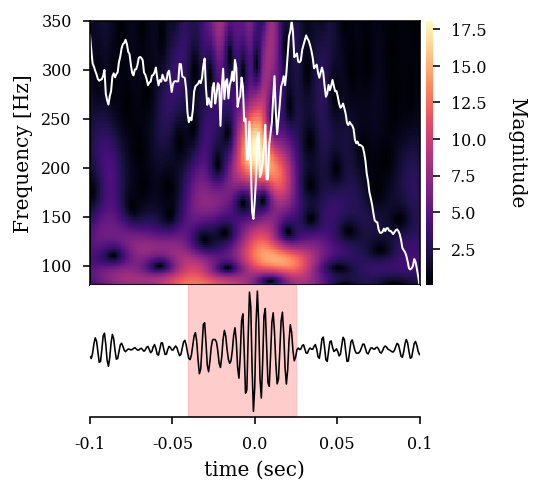

In [78]:
plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,LFPs)

## get average trace over session

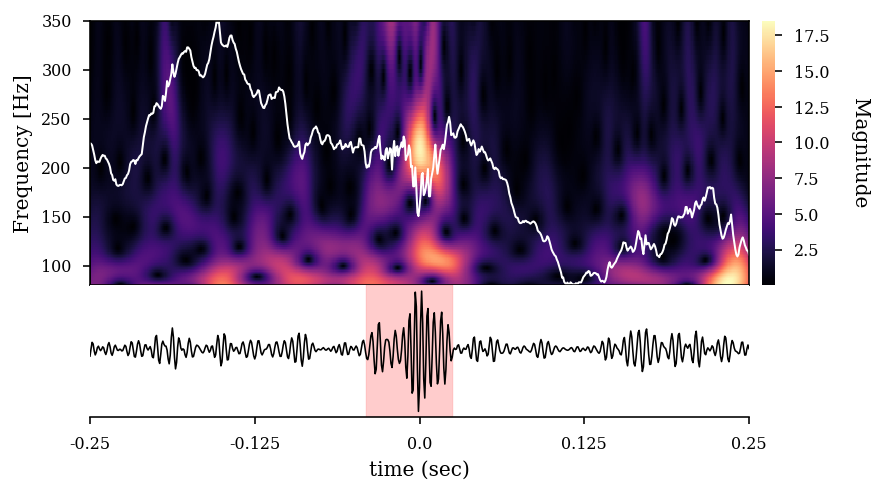

In [8]:
# set up figure
fig = plt.figure(figsize=set_size(426.79135,subplots=(1,1)),constrained_layout=False)
fig.subplots_adjust(hspace = 0, wspace=0.5)
gs = fig.add_gridspec(3, 1)
f_ax1 = fig.add_subplot(gs[0:2, :])
f_ax2 = fig.add_subplot(gs[2, :])

# plot scalogram
_,im = get_scalogram(lfp[idx,df.peak_channel[rip_n]],1250,f_min=80,f_max=350,ax=f_ax1)
f_ax1.set_xlabel('time (sec)')
f_ax1.get_xaxis().set_visible(False)

# set up parameters for colorbar
axins = inset_axes(f_ax1,
                   width="2%",  # width = 5% of parent_bbox width
                   height="100%",  # height : 50%
                   loc='lower left',
                   bbox_to_anchor=(1.02, 0., 1, 1),
                   bbox_transform=f_ax1.transAxes,
                   borderpad=0,
                   )
# plot colorbar
cbar = fig.colorbar(im,ax=f_ax1,cax=axins)
cbar.set_label('Magnitude', rotation=270, labelpad=20)
cbar.outline.set_visible(False)

# plot filtered trace
f_ax2.plot(ts[idx],filtered_lfps[idx,df.peak_channel[rip_n]],color='k',linewidth=0.8)
for ripple in temp_df[(temp_df.peak_time >= df.peak_time[rip_n] - x_range/2) & (temp_df.peak_time <= df.peak_time[rip_n] + x_range/2)].itertuples():
    f_ax2.axvspan(ripple.start_time, ripple.end_time, alpha=0.2, color='red', zorder=-1000) # #fec287
    
f_ax2.autoscale(enable=True, axis='x', tight=True)

# align x axis
locs = f_ax2.get_xticks()
labels = f_ax2.get_xticklabels()
f_ax2.set_xticks(np.linspace(min(ts[idx]), max(ts[idx]), 5))
f_ax2.set_xticklabels(np.linspace(-x_range/2,x_range/2,5))

# name x axis
f_ax2.set_xlabel('time (sec)')

# clean up y axis and box
f_ax2.get_yaxis().set_visible(False)
right_side = f_ax2.spines["right"]
right_side.set_visible(False)
left_side = f_ax2.spines["left"]
left_side.set_visible(False)
top_side = f_ax2.spines["top"]
top_side.set_visible(False)

# save plot
plt.savefig('ripple_trace_spectro.svg',dpi=900,bbox_inches='tight')
plt.savefig('ripple_trace_spectro.pdf',dpi=900,bbox_inches='tight')

In [54]:
idx = (df.ripple_duration > .05) & (df.ripple_duration < .07) & (df.group == 'pae') & (df.peak_amplitude > 5) & (df.peak_freq > 200) & (df.peak_freq < 230)

df[idx]

,ripple_number,start_time,end_time,ripple_duration,max_emg,peak_time,peak_channel,peak_amplitude,peak_freq,clipped,session,rat,group
6036,6036,163.0696,163.1232,0.0536,0.482619,163.0856,6,7.439071,213.639940,0.000000,LEM3124_S20190224154619,LEM3124,pae
6037,6037,198.3328,198.3968,0.0640,0.827548,198.3688,6,11.346152,208.097396,0.000000,LEM3124_S20190224154619,LEM3124,pae
6043,6043,349.7232,349.7896,0.0664,0.608493,349.7624,6,5.385029,212.758592,0.000000,LEM3124_S20190224154619,LEM3124,pae
6081,6081,802.4704,802.5248,0.0544,0.366098,802.5016,6,5.369749,208.431092,0.000000,LEM3124_S20190224154619,LEM3124,pae
6093,6093,1349.4280,1349.4920,0.0640,0.371219,1349.4560,6,6.361274,211.041807,0.006667,LEM3124_S20190224154619,LEM3124,pae
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52494,52494,462.6672,462.7264,0.0592,0.112742,462.7120,5,6.804595,201.776893,0.006667,RH16_S20161021165052,RH16,pae
52548,52548,127.4784,127.5456,0.0672,0.139967,127.5088,4,5.073489,205.173312,0.006667,RH16_S20161126145021,RH16,pae
52566,52566,285.8560,285.9200,0.0640,0.199760,285.8896,5,6.336674,217.463124,0.000000,RH16_S20161126145021,RH16,pae
52584,52584,127.3720,127.4360,0.0640,0.182656,127.3968,1,5.354143,212.732293,0.000000,RH16_S20161126150318,RH16,pae


In [47]:
# rip_n = 6037
rip_n = 6093
lfp,ts = get_lfp(df,rip_n)

# filter_ripple_band(lfp)
LFPs = lfp
filtered_lfps = np.stack([filter_ripple_band(lfp, 1250) for lfp in LFPs.T])
filtered_lfps = filtered_lfps.T

In [48]:
x_range = .200
idx = (ts >= df.peak_time[rip_n] - x_range/2) & (ts <= df.peak_time[rip_n] + x_range/2)
temp_df = df[df.session == df.session[rip_n]]

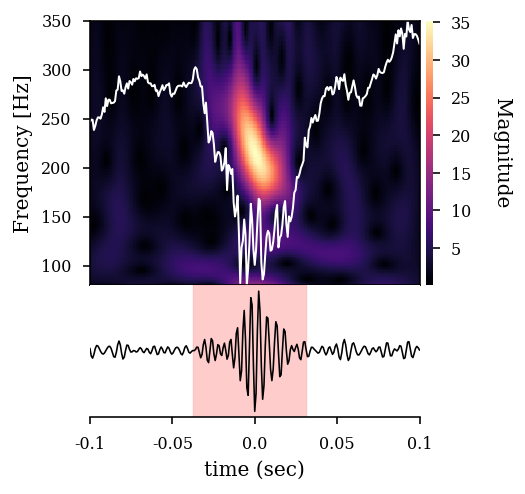

In [83]:
rip_n = 6394
# ripple_trace_spectro_6394

lfp,ts = get_lfp(df,rip_n)

# filter_ripple_band(lfp)
LFPs = lfp
filtered_lfps = np.stack([filter_ripple_band(lfp, 1250) for lfp in LFPs.T])
filtered_lfps = filtered_lfps.T

x_range = .200
idx = (ts >= df.peak_time[rip_n] - x_range/2) & (ts <= df.peak_time[rip_n] + x_range/2)
temp_df = df[df.session == df.session[rip_n]]

plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,LFPs)


# run through each ripple with the below parameters

In [ ]:
from IPython.display import display, clear_output

idx = (df.ripple_duration > .05) & (df.ripple_duration < .07) & (df.group == 'control') & (df.peak_amplitude > 5) & (df.peak_freq > 200) & (df.peak_freq < 230)

for rip_n in df[idx].index:
    lfp,ts = get_lfp(df,rip_n)

    # filter_ripple_band(lfp)
    LFPs = lfp
    filtered_lfps = np.stack([filter_ripple_band(lfp, 1250) for lfp in LFPs.T])
    filtered_lfps = filtered_lfps.T
    
    x_range = .200
    idx = (ts >= df.peak_time[rip_n] - x_range/2) & (ts <= df.peak_time[rip_n] + x_range/2)
    temp_df = df[df.session == df.session[rip_n]]
    
    plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,LFPs)
    clear_output()

In [81]:
def plot_spectogram(rip_n,temp_df,idx,x_range,filtered_lfps,LFPs):
    # set up figure
    fig = plt.figure(figsize=set_size('thesis',fraction=.5,subplots=(2,1)),constrained_layout=False)
    fig.subplots_adjust(hspace = 0, wspace=0.5)
    gs = fig.add_gridspec(3, 1)
    f_ax1 = fig.add_subplot(gs[0:2, :])
    f_ax2 = fig.add_subplot(gs[2, :])

    # plot scalogram
    _,im = get_scalogram(lfp[idx,df.peak_channel[rip_n]],1250,f_min=80,f_max=350,ax=f_ax1)
    f_ax1.set_xlabel('time (sec)')
    f_ax1.get_xaxis().set_visible(False)

    # set up parameters for colorbar
    axins = inset_axes(f_ax1,
                       width="2%",  # width = 5% of parent_bbox width
                       height="100%",  # height : 50%
                       loc='lower left',
                       bbox_to_anchor=(1.02, 0., 1, 1),
                       bbox_transform=f_ax1.transAxes,
                       borderpad=0,
                       )
    # plot colorbar
    cbar = fig.colorbar(im,ax=f_ax1,cax=axins)
    cbar.set_label('Magnitude', rotation=270, labelpad=20)
    cbar.outline.set_visible(False)

    # plot filtered trace
    f_ax2.plot(ts[idx],filtered_lfps[idx,df.peak_channel[rip_n]],color='k',linewidth=0.8)
    for ripple in temp_df[(temp_df.peak_time >= df.peak_time[rip_n] - x_range/2) & (temp_df.peak_time <= df.peak_time[rip_n] + x_range/2)].itertuples():
        f_ax2.axvspan(ripple.start_time, ripple.end_time, alpha=0.2, color='red', zorder=-1000) # #fec287

    f_ax2.autoscale(enable=True, axis='x', tight=True)

    # align x axis
    locs = f_ax2.get_xticks()
    labels = f_ax2.get_xticklabels()
    f_ax2.set_xticks(np.linspace(min(ts[idx]), max(ts[idx]), 5))
    f_ax2.set_xticklabels(np.linspace(-x_range/2,x_range/2,5))

    # name x axis
    f_ax2.set_xlabel('time (sec)')

    # clean up y axis and box
    f_ax2.get_yaxis().set_visible(False)
    right_side = f_ax2.spines["right"]
    right_side.set_visible(False)
    left_side = f_ax2.spines["left"]
    left_side.set_visible(False)
    top_side = f_ax2.spines["top"]
    top_side.set_visible(False)

    # save plot
    # plt.savefig('ripple_trace_spectro.svg',dpi=900,bbox_inches='tight')
    plt.savefig(df.group[rip_n]+'_ripple_examples/ripple_trace_spectro_'+str(rip_n)+'.pdf',dpi=900,bbox_inches='tight')
    plt.savefig(df.group[rip_n]+'_ripple_examples/ripple_trace_spectro_'+str(rip_n)+'.svg',dpi=900,bbox_inches='tight')